In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('../input/')
feature_dir = Path('../feature')
val_dir = Path('../txt/')
tst_dir = Path('../txt/')
sub_dir = Path('../submission')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = sub_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:

df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 26)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,g_r,u_g,r_i,i_z,u_r,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ug,d_dered_gr,d_dered_iz,d_dered_ur,d_dered_ri,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,1.3723,1.1898,0.0,1.3273,2.9272,1.3371,0.7328,4.2545,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,2.8665,1.3027,0.7232,4.1691,1.3230,2.1456
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.5266,1.2533,1.0,0.6096,0.9902,0.1840,0.0995,1.5997,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,0.9619,0.5931,0.1016,1.5550,0.1751,1.3163
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,0.7413,1.0225,0.0,0.2891,0.9610,0.1428,0.0435,1.2501,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,0.9211,0.2466,0.0257,1.1676,0.1183,1.4821
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,0.9591,1.2054,0.0,0.9676,4.4719,0.3262,0.2603,5.4395,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,4.3590,0.9074,0.2395,5.2664,0.2926,1.4454
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,1.2917,1.1939,0.0,1.6568,3.7543,0.7182,0.3415,5.4111,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,3.3376,1.5709,0.3144,4.9084,0.6727,1.9857


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 25) (80000, 25)


In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [9]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

In [10]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [02:18<00:00, 13.83s/trial, best loss: 0.158066307969685] 
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.9, 'learning_rate': 0.12037965418607384, 'min_child_samples': 100, 'num_leaves': 31, 'subsample': 0.9}


In [11]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [12]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.816881
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.695492
[3]	valid_0's multi_logloss: 0.602998
[4]	valid_0's multi_logloss: 0.53034
[5]	valid_0's multi_logloss: 0.472314
[6]	valid_0's multi_logloss: 0.425042
[7]	valid_0's multi_logloss: 0.389158
[8]	valid_0's multi_logloss: 0.356524
[9]	valid_0's multi_logloss: 0.329578
[10]	valid_0's multi_logloss: 0.30665
[11]	valid_0's multi_logloss: 0.287287
[12]	valid_0's multi_logloss: 0.27098
[13]	valid_0's multi_logloss: 0.256942
[14]	valid_0's multi_logloss: 0.245019
[15]	valid_0's multi_logloss: 0.234482
[16]	valid_0's multi_logloss: 0.22604
[17]	valid_0's multi_logloss: 0.21798
[18]	valid_0's multi_logloss: 0.210954
[19]	valid_0's multi_logloss: 0.204993
[20]	valid_0's multi_logloss: 0.199753
[21]	valid_0's multi_logloss: 0.195199
[22]	valid_0's multi_logloss: 0.191324
[23]	valid_0's multi_logloss: 0.187882
[24]	valid_0's multi_logloss: 0

[43]	valid_0's multi_logloss: 0.164077
[44]	valid_0's multi_logloss: 0.163649
[45]	valid_0's multi_logloss: 0.163332
[46]	valid_0's multi_logloss: 0.163129
[47]	valid_0's multi_logloss: 0.162737
[48]	valid_0's multi_logloss: 0.162494
[49]	valid_0's multi_logloss: 0.162239
[50]	valid_0's multi_logloss: 0.162002
[51]	valid_0's multi_logloss: 0.161827
[52]	valid_0's multi_logloss: 0.161624
[53]	valid_0's multi_logloss: 0.1614
[54]	valid_0's multi_logloss: 0.161261
[55]	valid_0's multi_logloss: 0.161048
[56]	valid_0's multi_logloss: 0.160992
[57]	valid_0's multi_logloss: 0.160838
[58]	valid_0's multi_logloss: 0.16071
[59]	valid_0's multi_logloss: 0.16058
[60]	valid_0's multi_logloss: 0.160498
[61]	valid_0's multi_logloss: 0.160404
[62]	valid_0's multi_logloss: 0.160306
[63]	valid_0's multi_logloss: 0.160245
[64]	valid_0's multi_logloss: 0.160119
[65]	valid_0's multi_logloss: 0.15999
[66]	valid_0's multi_logloss: 0.159913
[67]	valid_0's multi_logloss: 0.15986
[68]	valid_0's multi_logloss: 0

[88]	valid_0's multi_logloss: 0.159082
[89]	valid_0's multi_logloss: 0.15905
[90]	valid_0's multi_logloss: 0.159039
[91]	valid_0's multi_logloss: 0.159041
[92]	valid_0's multi_logloss: 0.159011
[93]	valid_0's multi_logloss: 0.158948
[94]	valid_0's multi_logloss: 0.15893
[95]	valid_0's multi_logloss: 0.158899
[96]	valid_0's multi_logloss: 0.158906
[97]	valid_0's multi_logloss: 0.158916
[98]	valid_0's multi_logloss: 0.158915
[99]	valid_0's multi_logloss: 0.15886
[100]	valid_0's multi_logloss: 0.158842
[101]	valid_0's multi_logloss: 0.158834
[102]	valid_0's multi_logloss: 0.158811
[103]	valid_0's multi_logloss: 0.158787
[104]	valid_0's multi_logloss: 0.158734
[105]	valid_0's multi_logloss: 0.158772
[106]	valid_0's multi_logloss: 0.158753
[107]	valid_0's multi_logloss: 0.158746
[108]	valid_0's multi_logloss: 0.158753
[109]	valid_0's multi_logloss: 0.158714
[110]	valid_0's multi_logloss: 0.158688
[111]	valid_0's multi_logloss: 0.158677
[112]	valid_0's multi_logloss: 0.158616
[113]	valid_0's

[152]	valid_0's multi_logloss: 0.1569
[153]	valid_0's multi_logloss: 0.156865
[154]	valid_0's multi_logloss: 0.156865
[155]	valid_0's multi_logloss: 0.156855
[156]	valid_0's multi_logloss: 0.15686
[157]	valid_0's multi_logloss: 0.15686
[158]	valid_0's multi_logloss: 0.156856
[159]	valid_0's multi_logloss: 0.15686
[160]	valid_0's multi_logloss: 0.156823
[161]	valid_0's multi_logloss: 0.156769
[162]	valid_0's multi_logloss: 0.156795
[163]	valid_0's multi_logloss: 0.156791
[164]	valid_0's multi_logloss: 0.1568
[165]	valid_0's multi_logloss: 0.156791
[166]	valid_0's multi_logloss: 0.15679
[167]	valid_0's multi_logloss: 0.156804
[168]	valid_0's multi_logloss: 0.156798
[169]	valid_0's multi_logloss: 0.156804
[170]	valid_0's multi_logloss: 0.156761
[171]	valid_0's multi_logloss: 0.15677
[172]	valid_0's multi_logloss: 0.156752
[173]	valid_0's multi_logloss: 0.156732
[174]	valid_0's multi_logloss: 0.15668
[175]	valid_0's multi_logloss: 0.156725
[176]	valid_0's multi_logloss: 0.156724
[177]	vali

In [13]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3975%


In [14]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [15]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

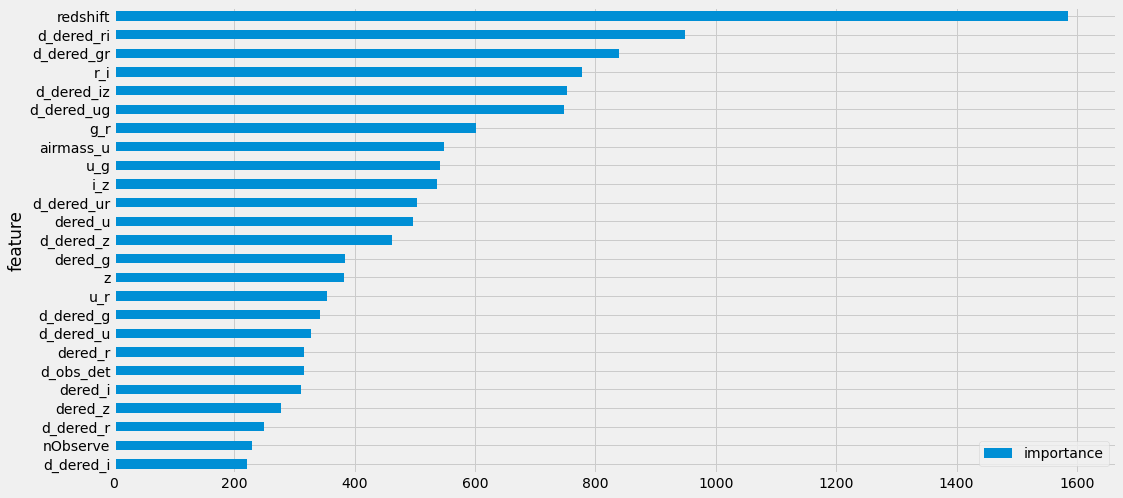

In [16]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [19]:
sub[target_col].value_counts()

2    40745
0    29988
1     9267
Name: class, dtype: int64

In [ ]:
sub.to_csv(sub_file)